In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from scipy.special import legendre
from scipy import integrate

from math import sqrt, factorial, floor


##  Material properties of Aluminium

In [3]:
rho = 2700  # Density in kg/m^3
E = 69e9    # Young's modulus in Pa
v = 0.33   # Poisson's ratio

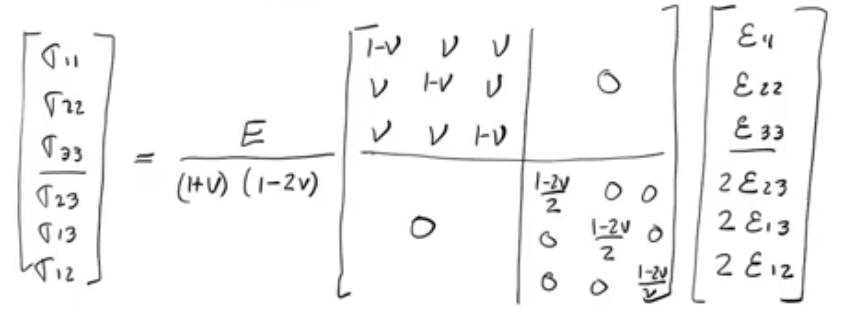

wave equation: https://wiki.seg.org/wiki/Mathematical_foundation_of_elastic_wave_propagation

derivation of matrices: https://jemmmm.notion.site/Scanned-Documents-19fc059ed4a180708a97fa485234ba20?pvs=4

**recasting (linear companion method) from [this](https://doi.org/10.1080/15376494.2020.1860273) paper**

# PINN

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import qmc

import scipy.linalg
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

###   Data

**For k_sample**
* Use pre-recorded github data for dispersion curve of aluminium plate
  OR
* Use values from one of our plots above

**For k_pred**
* PINN outputs

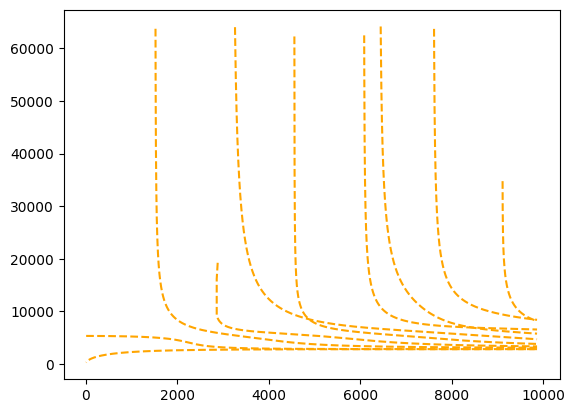

In [5]:
# Using pre-recorded github data
import pandas as pd

# import phase velocities
# /kaggle/input/aluminium-1mm/alum1mm.xlsx
df_vp = pd.read_excel('/kaggle/input/aluminium-1mm/alum1mm.xlsx', skiprows = 9, usecols = 'U:AN', 
                      header=None)
# for group velocity- ignoring that
# df_vg = pd.read_excel('/kaggle/input/aluminium-1mm/alum1mm.xlsx', skiprows = 9, usecols = 'A:T', 
#                       header=None)

for mode in df_vp.columns[::2]:
    plt.plot(df_vp[mode]*1e3, df_vp[mode+1]*1e3, 
             color = 'orange', 
             linestyle='--')

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


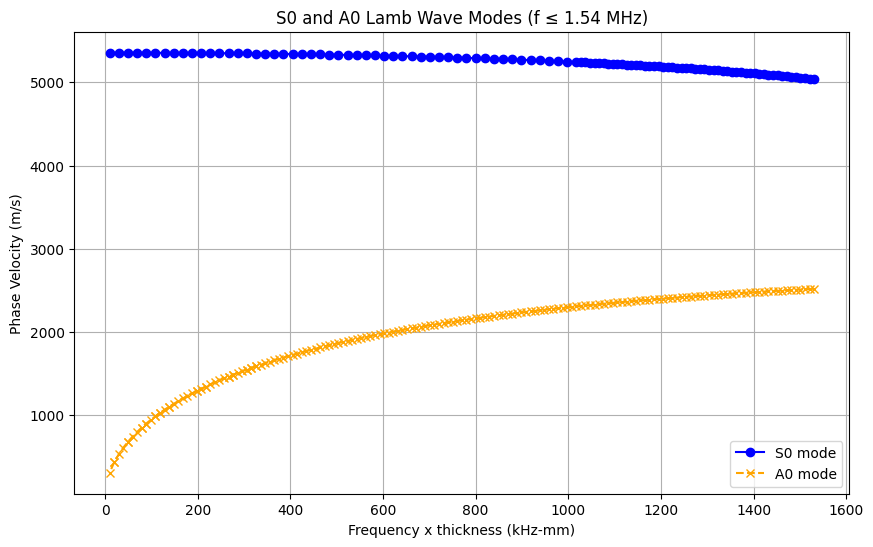

In [6]:
# Extract S0 data (col U, V)
df_S0_raw = df_vp.iloc[:, 0:2]
df_S0_raw.columns = ['F_S0', 'v_S0']
df_S0 = df_S0_raw[df_S0_raw['F_S0'] <= 1.54]

# Extract A0 data (col AE, AF)
df_A0_raw = df_vp.iloc[:, 10:12]
df_A0_raw.columns = ['F_A0', 'v_A0']
df_A0 = df_A0_raw[df_A0_raw['F_A0'] <= 1.54]

plt.figure(figsize=(10, 6))
plt.plot(df_S0['F_S0']*1e3, df_S0['v_S0']*1e3, 
         color='blue', linestyle='-', marker='o', label='S0 mode')
plt.plot(df_A0['F_A0']*1e3, df_A0['v_A0']*1e3, 
         color='orange', linestyle='--', marker='x', label='A0 mode')

plt.xlabel('Frequency x thickness (kHz-mm)')
plt.ylabel('Phase Velocity (m/s)')
plt.title('S0 and A0 Lamb Wave Modes (f ≤ 1.54 MHz)')
plt.legend()
plt.grid(True)
plt.show()

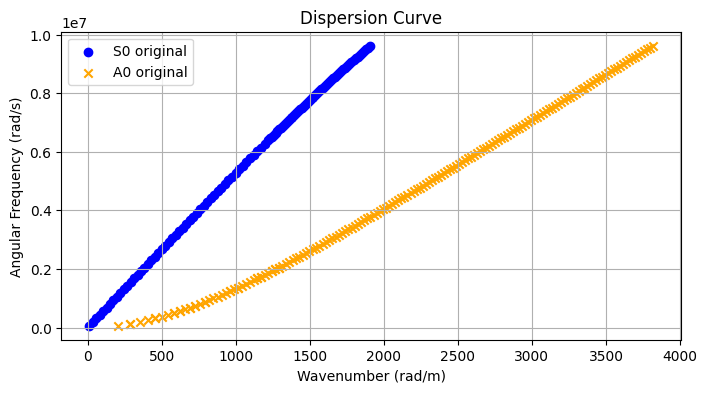

In [7]:
k_values = []
omega_values = []
mode_labels = []  # To keep track of k mode

# For S0
for i, row in df_S0.iterrows():
    f_hz = row['F_S0'] * 1e6     
    v_ms = row['v_S0'] * 1e3      
    omega = 2 * np.pi * f_hz      
    k = omega / v_ms
    
    k_values.append(k)
    omega_values.append(omega)
    mode_labels.append('S0')

# For A0
for i, row in df_A0.iterrows():
    f_hz = row['F_A0'] * 1e6      
    v_ms = row['v_A0'] * 1e3
    omega = 2 * np.pi * f_hz
    k = omega / v_ms
    
    k_values.append(k)
    omega_values.append(omega)
    mode_labels.append('A0')

S0_A0_df = pd.DataFrame({
    'wavenumber': k_values,
    'omega': omega_values,
    'mode': mode_labels
})
# len(omega_values) #273
plt.figure(figsize=(8, 4))
s0_mask = np.array(mode_labels) == 'S0'
plt.scatter(np.array(k_values)[s0_mask], np.array(omega_values)[s0_mask], 
           color='blue', marker='o', label='S0 original')

a0_mask = np.array(mode_labels) == 'A0'
plt.scatter(np.array(k_values)[a0_mask], np.array(omega_values)[a0_mask], 
           color='orange', marker='x', label='A0 original')

plt.xlabel('Wavenumber (rad/m)')
plt.ylabel('Angular Frequency (rad/s)')
plt.title('Dispersion Curve')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
S0_A0_df.omega.dtype
print(min(omega_values))

62058.537957066066


In [9]:
print(type(S0_A0_df['mode'].iloc[0]))
print(S0_A0_df['mode'].unique())

mode_mapping = {'S0': 0, 'A0': 1}  # Create a mapping
S0_A0_df['mode'] = S0_A0_df['mode'].map(mode_mapping)
print(type(S0_A0_df['mode'].iloc[0]))
print(S0_A0_df['mode'].unique())

<class 'str'>
['S0' 'A0']
<class 'numpy.int64'>
[0 1]


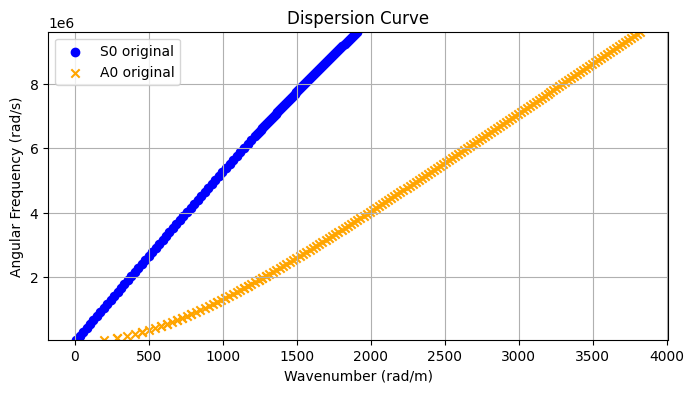

In [10]:
plt.figure(figsize=(8, 4))
plt.ylim(min(omega_values), max(omega_values))

s0_mask = np.array(mode_labels) == 'S0'
plt.scatter(np.array(k_values)[s0_mask], np.array(omega_values)[s0_mask], 
           color='blue', marker='o', label='S0 original')

a0_mask = np.array(mode_labels) == 'A0'
plt.scatter(np.array(k_values)[a0_mask], np.array(omega_values)[a0_mask], 
           color='orange', marker='x', label='A0 original')

plt.xlabel('Wavenumber (rad/m)')
plt.ylabel('Angular Frequency (rad/s)')
plt.title('Dispersion Curve')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Omega range: 62058.54 rad/s to 9619073.38 rad/
#  no. of k_values, omega_values from data columns = 273

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [15]:
class DispersionDataset(Dataset):
    def __init__(self, df, normalize=True):

        self.k_values = df['wavenumber'].values
        self.omega_values = df['omega'].values
        self.mode_labels = df['mode'].values
        
        # Normalize data
        self.omega_mean, self.omega_std = np.mean(self.omega_values), np.std(self.omega_values)
        self.k_mean, self.k_std = np.mean(self.k_values), np.std(self.k_values)
            
        self.omega_normalized = (self.omega_values - self.omega_mean) / self.omega_std
        self.k_normalized = (self.k_values - self.k_mean) / self.k_std
            
        #to tensor
        self.omega_tensor = torch.FloatTensor(self.omega_normalized).unsqueeze(1)
        self.k_tensor = torch.FloatTensor(self.k_normalized).unsqueeze(1)

        self.mode_tensor = torch.LongTensor(self.mode_labels)
        
    def __len__(self):
        return len(self.k_values)
    
    def __getitem__(self, idx):
        return self.omega_tensor[idx], self.k_tensor[idx], self.mode_tensor[idx]
    
    def get_normalization_params(self):
        """Return normalization parameters for denormalization later"""
        return {
            'omega_mean': self.omega_mean,
            'omega_std': self.omega_std,
            'k_mean': self.k_mean,
            'k_std': self.k_std
        }

In [14]:
class PgMDN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_gaussians=2):
        super(PgMDN, self).__init__()
        # training for 2 modes, so 2 gaussians
        self.num_gaussians = num_gaussians
        
        self.hidden_layer1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.pi_layer = nn.Linear(hidden_dim, num_gaussians)  # mixing weights
        self.mu_layer = nn.Linear(hidden_dim, num_gaussians)  # means
        self.sigma_layer = nn.Linear(hidden_dim, num_gaussians)  # standard deviations
        
    def forward(self, x):
        h = F.relu(self.hidden_layer1(x))
        h = F.relu(self.hidden_layer2(h))
        
        pi = F.softmax(self.pi_layer(h), dim=1)  # mixing weights (sum to 1)
        mu = self.mu_layer(h)  # means
        sigma = torch.exp(self.sigma_layer(h))  # standard deviations (positive)
        
        return pi, mu, sigma

In [16]:
# MDN loss function
def mdn_loss(pi, mu, sigma, target):
    """
    Negative log likelihood loss for a mixture of Gaussians
    """
    target = target.expand_as(mu)
    
    # Calculate Gaussian probability densities
    normal_dist = torch.distributions.Normal(mu, sigma)
    log_prob = normal_dist.log_prob(target)
    
    # Weight by mixing coefficients
    weighted_logprob = log_prob + torch.log(pi + 1e-8)
    
    # Sum across mixture components
    log_sum = torch.logsumexp(weighted_logprob, dim=1)
    
    # Return negative log likelihood
    return -torch.mean(log_sum)

In [17]:
def train_model(model, train_loader, optimizer, num_epochs=200, scheduler=None):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for omega, k, _ in train_loader:
            optimizer.zero_grad()
            # Forward pass
            pi, mu, sigma = model(omega)
            loss = mdn_loss(pi, mu, sigma, k)
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if scheduler:
            scheduler.step()
            
        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f} ")
    
    return {'loss': losses}


In [ ]:
'''
# Function to sample from the trained model
def sample_from_mdn(model, omega_values, norm_params=None, num_samples=10):
    model.eval()
    samples = []
    modes = []
    
    omega_normalized = (omega_values - norm_params['omega_mean']) / norm_params['omega_std']
    
    with torch.no_grad():
        # Convert to tensor
        omega_tensor = torch.FloatTensor(omega_normalized).unsqueeze(1)
        
        # Get MDN parameters
        pi, mu, sigma = model(omega_tensor)
        
        # For each input frequency
        for i in range(len(omega_values)):
            # For each sample
            omega_samples = []
            omega_modes = []
            
            for _ in range(num_samples):
                # Sample mixture component based on pi
                component = torch.multinomial(pi[i], 1).item()
                
                # Sample from the Gaussian
                normal_dist = torch.distributions.Normal(mu[i, component], sigma[i, component])
                k_sample = normal_dist.sample().item()
                
                omega_samples.append(k_sample)
                omega_modes.append(component)
            
            samples.append(omega_samples)
            modes.append(omega_modes)
    
    samples = np.array(samples) * norm_params['k_std'] + norm_params['k_mean']
    
    return samples, np.array(modes)
'''

In [18]:
# Function to get the predicted means for each component
def get_mdn_predictions(model, omega_values, norm_params):
    model.eval()
    
    omega_normalized = (omega_values - norm_params['omega_mean']) / norm_params['omega_std']
    
    with torch.no_grad():
        # Convert to tensor
        omega_tensor = torch.FloatTensor(omega_normalized).unsqueeze(1)
        
        # Get MDN parameters
        pi, mu, sigma = model(omega_tensor)
        
        # Convert to numpy
        pi_np = pi.numpy()
        mu_np = mu.numpy()
        sigma_np = sigma.numpy()

    mu_np = mu_np * norm_params['k_std'] + norm_params['k_mean']
    sigma_np = sigma_np * norm_params['k_std']
    
    return pi_np, mu_np, sigma_np

In [4]:
    '''
# Plot dispersion curves and model predictions
def plot_results(df, model, norm_params, save_path=None):
    plt.figure(figsize=(12, 8))
    
    # Plot training data
    modes = df['mode'].unique()
    for mode in modes:
        mode_data = df[df['mode'] == mode]
        plt.scatter(mode_data['omega'], mode_data['wavenumber'], s=10, alpha=0.5, 
                   label=f"Mode {mode} original")
    # If test omega is provided, get model predictions
    if test_omega is not None:
        pi_np, mu_np, sigma_np = get_mdn_predictions(model, test_omega, norm_params)
        
        # Plot the means for each component
        for i in range(model.num_gaussians):
            plt.plot(test_omega, mu_np[:, i], '-', linewidth=2, 
                     label=f"MDN Mode {i}")
            # Plot confidence intervals (+/- 2 sigma)
            plt.fill_between(test_omega, 
                            mu_np[:, i] - 2 * sigma_np[:, i],
                            mu_np[:, i] + 2 * sigma_np[:, i],
                            alpha=0.2)
    
    plt.title("Dispersion Curve Prediction with PgMDN")
    plt.xlabel("Angular Frequency (rad/s)")
    plt.ylabel("Wavenumber (rad/m)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    return plt
    '''

In [19]:
def plot_results(df, model, norm_params, save_path=None):
    """Plot dispersion curves and model predictions"""
    # Get original data points
    omega_values = df['omega'].values
    k_values = df['wavenumber'].values
    mode_labels = df['mode'].values
    
    # Generate a dense grid of points for prediction
    omega_min, omega_max = np.min(omega_values), np.max(omega_values)
    omega_dense = np.linspace(omega_min, omega_max, 1000)
    
    # Get predictions
    pi_np, mu_np, sigma_np = get_mdn_predictions(model, omega_dense, norm_params)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot original data points
    for mode in np.unique(mode_labels):
        mask = mode_labels == mode
        plt.scatter(omega_values[mask], k_values[mask], 
                   label=f'Mode {mode} (Data)', alpha=0.6, s=10)
    
    # Plot predicted curves (mean of each Gaussian component)
    for i in range(model.num_gaussians):
        plt.plot(omega_dense, mu_np[:, i], 
                label=f'Predicted Mode {i}', linestyle='--', linewidth=2)
        
        # Optionally plot confidence intervals
        plt.fill_between(omega_dense, 
                         mu_np[:, i] - 2*sigma_np[:, i], 
                         mu_np[:, i] + 2*sigma_np[:, i], 
                         alpha=0.2)
    
    plt.xlabel('Frequency (ω)')
    plt.ylabel('Wavenumber (k)')
    plt.title('Dispersion Curves: Data vs MDN Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [20]:
def load_model(model_path):
    """Load a trained model from checkpoint"""
    checkpoint = torch.load(model_path)
    
    # Create model with the same architecture
    model = PgMDN(input_dim=1, hidden_dim=128, num_gaussians=checkpoint['num_gaussians'])
    
    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Get normalization parameters
    norm_params = checkpoint['norm_params']
    
    return model, norm_params

In [31]:
def evaluate_model(model, test_loader):
    """Evaluate model on test data using the same loss function as training"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for omega, k, _ in test_loader:
            pi, mu, sigma = model(omega)
            loss = mdn_loss(pi, mu, sigma, k)
            total_loss += loss.item() * omega.size(0)
    
    return total_loss / len(test_loader.dataset)

In [33]:
def main():
    dataset = DispersionDataset(S0_A0_df, normalize=True)
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    indices = list(range(len(S0_A0_df)))
    train_indices, test_indices = indices[:train_size], indices[train_size:]
    
    # train_df, test_df = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_df = S0_A0_df.iloc[train_indices]
    test_df = S0_A0_df.iloc[test_indices]
    
    # Create datasets from the split DataFrames
    train_dataset = DispersionDataset(train_df, normalize=True)
    test_dataset = DispersionDataset(test_df, normalize=True)
    
    # train_dataset = DispersionDataset(train_df, normalize=True)
    # test_dataset = DispersionDataset(test_df, normalize=True)
    
    norm_params = train_dataset.get_normalization_params()
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = PgMDN(input_dim=1, hidden_dim=128, num_gaussians=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    training_history = train_model(
        model, train_loader, optimizer, 
        num_epochs=200, scheduler=scheduler
    )
    
    # 5. Evaluate model
    test_loss = evaluate_model(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    
    # 6. Plot results
    plot_results(S0_A0_df, model, norm_params, save_path='dispersion_curves.png')
    
    # 7. Save model
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'norm_params': norm_params,
        'num_gaussians': model.num_gaussians
    }
    torch.save(checkpoint, 'mdn_dispersion_model.pth')
    
    print("Training completed and model saved successfully!")

Epoch 20/200, Loss: -0.9819 
Epoch 40/200, Loss: -0.7917 
Epoch 60/200, Loss: -1.4995 
Epoch 80/200, Loss: -1.7869 
Epoch 100/200, Loss: -2.4819 
Epoch 120/200, Loss: -2.8716 
Epoch 140/200, Loss: -3.0432 
Epoch 160/200, Loss: -3.4895 
Epoch 180/200, Loss: 1.5736 
Epoch 200/200, Loss: -3.5139 
Test Loss: 6894.0356


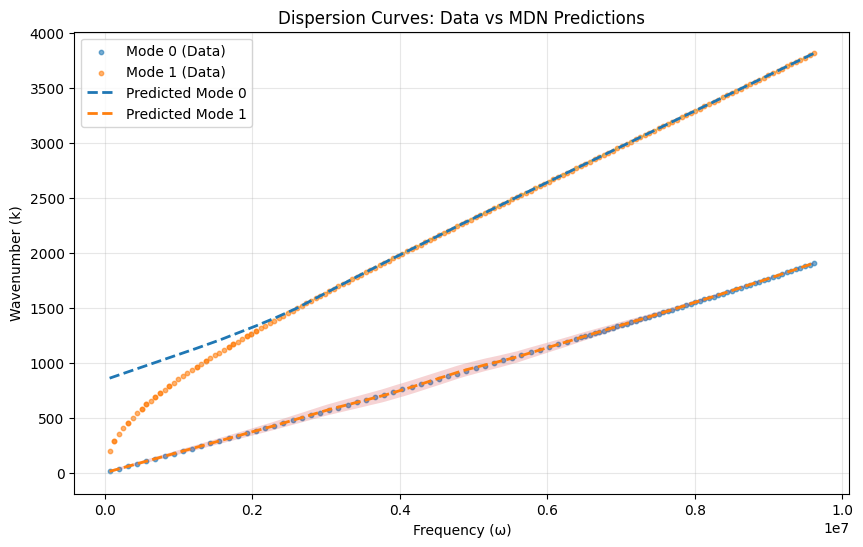

Training completed and model saved successfully!


In [34]:
if __name__ == "__main__":
    main()

In [5]:
'''
def plot_losses(losses_dict):
    plt.figure(figsize=(12, 6))
    plt.plot(losses_dict['loss'], label='Total Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    '''

In [ ]:
'''
# Function to evaluate model on test data
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for omega, k, _ in test_loader:
            pi, mu, sigma = model(omega)
            loss = mdn_loss(pi, mu, sigma, k)
            total_loss += loss.item() * omega.size(0)
    
    return total_loss / len(test_loader.dataset)
    '''

In [ ]:
'''
def main():
    # Step 1: Create dataset and dataloader
    dataset = DispersionDataset(S0_A0_df, normalize=True)
    norm_params = dataset.get_normalization_params()
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Step 2: Initialize model, optimizer, and scheduler
    model = PgMDN(input_dim=1, hidden_dim=128, num_gaussians=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    # Step 3: Train the model
    losses = train_model(model, train_loader, optimizer, num_epochs=300, 
                        scheduler=scheduler)
    
    # Step 4: Plot training losses
    plot_losses(losses)

    # Step 5: Evaluate model on test set
    test_loss = evaluate_model(model, test_loader)
    print(f"Test set loss: {test_loss:.4f}")
    
    # Step 5: Generate test data for visualization
    test_omega = np.linspace(min(S0_A0_df['omega']), max(S0_A0_df['omega']), 200)
    
    # Step 6: Plot results
    plt_obj = plot_results(S0_A0_df, model, norm_params, test_omega)
    plt_obj.savefig('model_predictions.png')
    plt_obj.show()
    
    # Step 7: Test with specific frequencies (example)
    test_freq = np.array([2e6, 4e6, 6e6])  # Example test frequencies

    # Step 8: Plot predictions vs actual for test set
    plot_test_comparison(model, test_dataset, norm_params)
    
    # Get predictions
    pi_test, mu_test, sigma_test = get_mdn_predictions(model, test_freq, norm_params)
    
    print("\nPredictions for specific frequencies:")
    for i, freq in enumerate(test_freq):
        print(f"\nFrequency: {freq:.2e} rad/s")
        for j in range(model.num_gaussians):
            print(f"  Mode {j}: k = {mu_test[i, j]:.2f} ± {2*sigma_test[i, j]:.2f} rad/m (weight: {pi_test[i, j]:.2f})")
    
    # Step 8: Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'norm_params': norm_params,
        'num_gaussians': model.num_gaussians
    }, 'pgmdn_dispersion_model.pth')
    
    print("\nModel saved to 'pgmdn_dispersion_model.pth'")
    
    return model, norm_params
  '''  

In [ ]:
'''
# Function to load a trained model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    
    # Create model with the same architecture
    model = PgMDN(input_dim=1, hidden_dim=128, num_gaussians=checkpoint['num_gaussians'])
    
    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Get normalization parameters
    norm_params = checkpoint['norm_params']
    
    return model, norm_params
    '''

In [ ]:
'''
# Usage example for making predictions with a saved model
def predict_with_saved_model(model_path, omega_values):
    model, norm_params = load_model(model_path)
    pi, mu, sigma = get_mdn_predictions(model, omega_values, norm_params)
    
    return pi, mu, sigma
    '''

In [ ]:
'''
if __name__ == "__main__":
    trained_model, normalization_params = main()
    
    # Example of how to use the saved model for predictions
    print("\nExample of loading the model and making predictions:")
    test_omega = np.array([3e6, 5e6, 7e6])
    pi, mu, sigma = predict_with_saved_model('pgmdn_dispersion_model.pth', test_omega)
    
    for i, freq in enumerate(test_omega):
        print(f"\nFrequency: {freq:.2e} rad/s")
        for j in range(pi.shape[1]):
            print(f"  Mode {j}: k = {mu[i, j]:.2f} ± {2*sigma[i, j]:.2f} rad/m (weight: {pi[i, j]:.2f})")
            '''